# KeyWord Extraction

Question: What are the top keywords for all the papers?

Answer: Top 10 keywords: [('model', 78186), ('use', 42882), ('training', 28528), ('language', 27349), ('task', 23502), ('train', 20948), ('image', 19266), ('network', 19247), ('dataset', 18421), ('result', 18229)]

Total number of unique keywords assessed: 329163

Papers: 754/754

In [1]:
!pip install requests PyPDF2 tqdm


import pandas as pd
import requests
from tqdm import tqdm
import os
from PyPDF2 import PdfReader
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords

import spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.8 MB/s eta 0:00:00


In [ ]:
# English language model
nlp = spacy.load("en_core_web_sm")

# stopwords to exclude (e.g. the, is, and...)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# biblio words
additional_stopwords = ['et', 'al']

!pip install beautifulsoup4
from bs4 import BeautifulSoup

import logging
logging.getLogger("PyPDF2").setLevel(logging.ERROR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.3 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._dete

ModuleNotFoundError: No module named 'PyPDF2'

In [ ]:
# create directories: one for storing the downloaded PDFs and another for storing the converted text files

!mkdir pdfs
!mkdir texts

In [ ]:
pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/all_systems.csv")

# Detour for Extracting Some Information:

Institution and Category Organization (e.g. academia, industry, government, etc.)

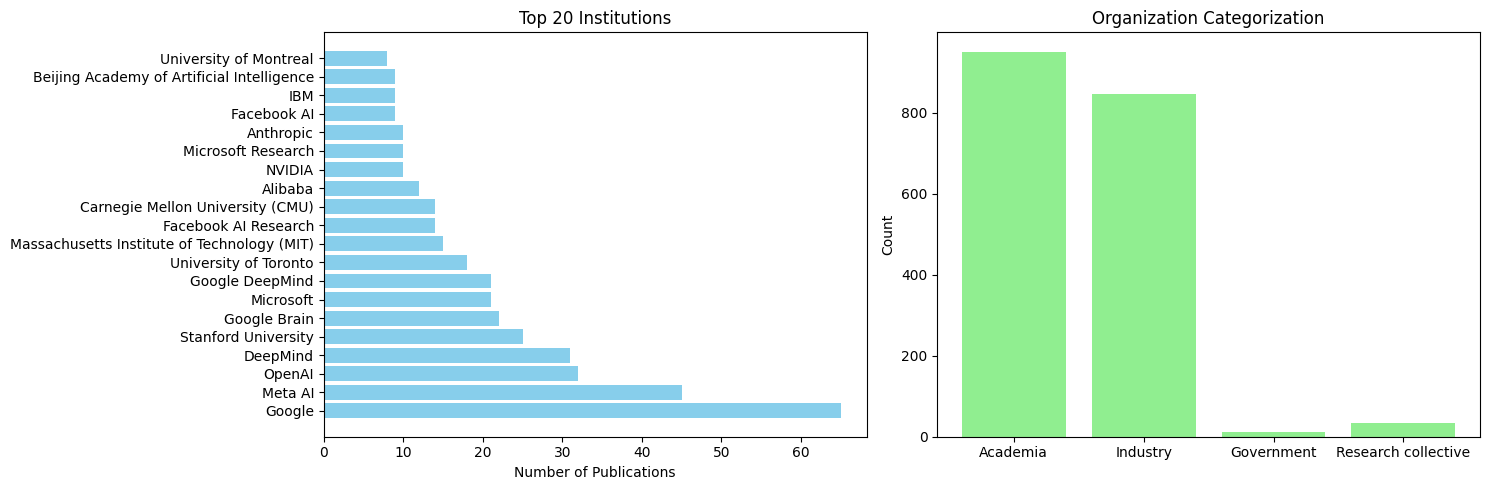

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/all_systems.csv")

# filtering out rows with missing values in 'Organization' or 'Organization categorization'
pcd_dataset = pcd_dataset.dropna(subset=['Organization', 'Organization categorization'])

all_categories = []
for categorization in pcd_dataset['Organization categorization']:
    categories = [cat.strip() for cat in categorization.split(',')]
    all_categories.extend(categories)

# count each unique category
category_counts = Counter(all_categories)

plt.rcParams['font.family'] = 'Times New Roman'

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

top_20_institutions = pcd_dataset['Organization'].value_counts().head(20)

# top 20 institutions
axs[0].barh(top_20_institutions.index, top_20_institutions.values, color='skyblue')
axs[0].set_xlabel('Number of Publications')
axs[0].set_title('Top 20 Institutions')

# categorization of institutions
axs[1].bar(category_counts.keys(), category_counts.values(), color='lightgreen')
axs[1].set_ylabel('Count')
axs[1].set_title('Organization Categorization')

plt.tight_layout()
plt.show()



Geography

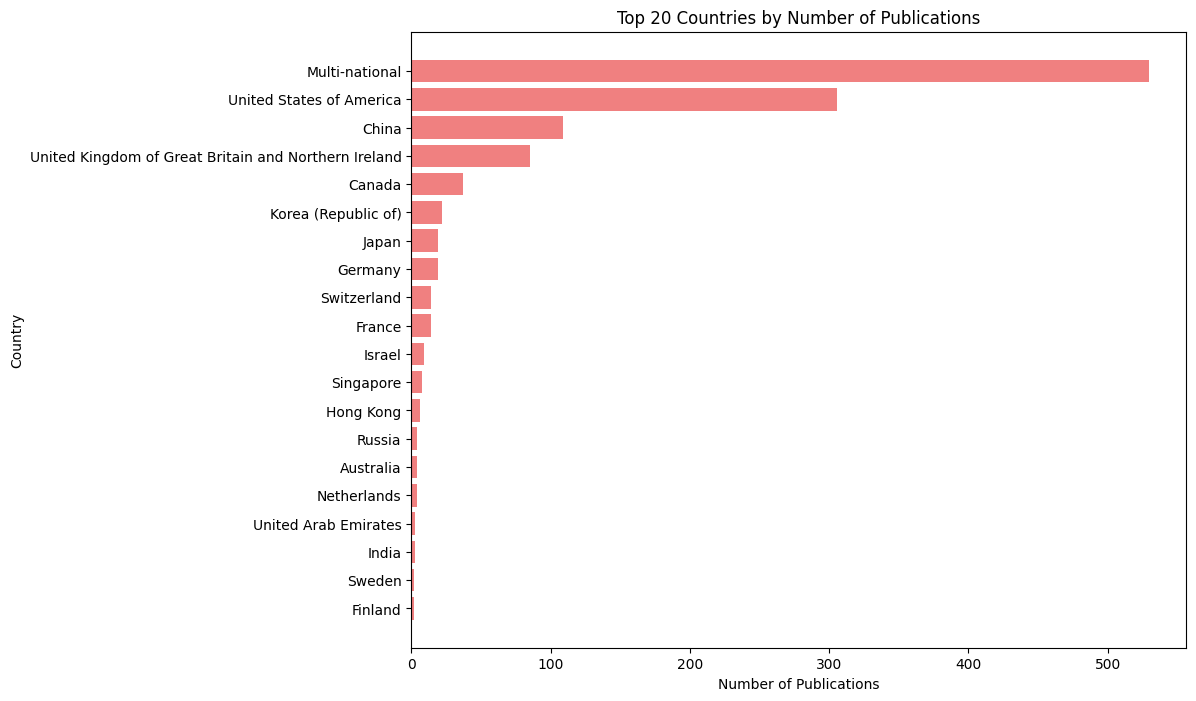

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

# Load the dataset
pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/all_systems.csv")

def normalize_country_names(country_entry):
    if pd.isna(country_entry):
        return None
    # normalizes the United Kingdom variations
    country_entry = re.sub(r'United Kingdom.*', 'United Kingdom of Great Britain and Northern Ireland', country_entry)
    # replaces variations of 'multinational' with 'Multi-national'
    country_entry = re.sub(r'multi[-\s]*national', 'Multi-national', country_entry, flags=re.IGNORECASE)
    countries = set(re.split(r'[,/]', country_entry))
    countries = {country.strip() for country in countries if country.strip()}
    # checks for multi-national (if there's more than one unique country or the standardized term 'Multi-national')
    if len(countries) > 1 or 'Multi-national' in countries:
        return 'Multi-national'
    return countries.pop()

pcd_dataset['Normalized Country'] = pcd_dataset['Country (from Organization)'].apply(normalize_country_names)

pcd_dataset = pcd_dataset.dropna(subset=['Normalized Country'])

top_countries = pcd_dataset['Normalized Country'].value_counts().head(20)

plt.figure(figsize=(10, 8))
plt.barh(top_countries.index, top_countries.values, color='lightcoral')
plt.xlabel('Number of Publications')
plt.ylabel('Country')
plt.title('Top 20 Countries by Number of Publications')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest count on top
plt.show()



Open Source?

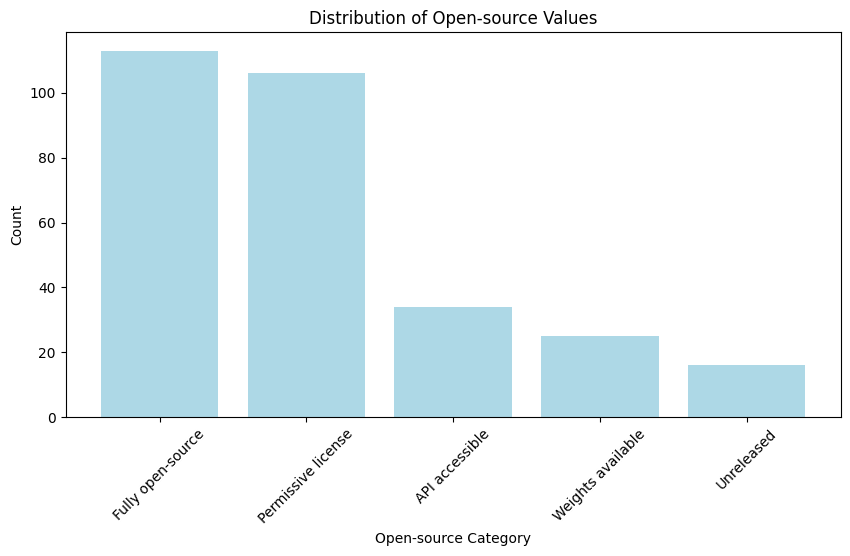

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/all_systems.csv")

# counts the unique values in the 'Open-source' column
open_source_counts = pcd_dataset['Open-source'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(open_source_counts.index, open_source_counts.values, color='lightblue')
plt.xlabel('Open-source Category')
plt.ylabel('Count')
plt.title('Distribution of Open-source Values')
plt.xticks(rotation=45)
plt.show()


Gender of Authors (according to classifier)

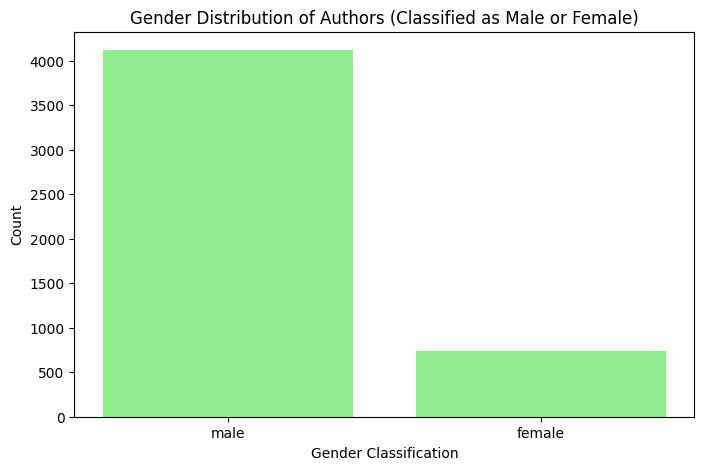

In [29]:
import pandas as pd
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
from collections import Counter

pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/all_systems.csv")

detector = gender.Detector()

def get_first_name(full_name):
    parts = full_name.split()
    return parts[0] if parts else ""

def classify_gender(name):
    gender = detector.get_gender(name)
    if gender == "mostly_male":
        return "male"
    elif gender == "mostly_female":
        return "female"
    return gender

gender_distribution = []
for authors in pcd_dataset['Authors'].dropna():
    first_names = [get_first_name(author.strip()) for author in authors.split(',') if author.strip()]
    genders = [classify_gender(name) for name in first_names]
    gender_distribution.extend(genders)

gender_distribution = [gender for gender in gender_distribution if gender in ["male", "female"]]

gender_counts = Counter(gender_distribution)

plt.figure(figsize=(8, 5))
plt.bar(gender_counts.keys(), gender_counts.values(), color=['lightgreen', 'lightgreen'])
plt.xlabel('Gender Classification')
plt.ylabel('Count')
plt.title('Gender Distribution of Authors (Classified as Male or Female)')
plt.show()



In [ ]:
def get_pdf_url(link):
    if link.endswith(".pdf"):
        return link
    elif "arxiv.org" in link:
        return link.replace("abs", "pdf") + ".pdf"
    elif "nature.com" in link:
        # BeautifulSoup to find the PDF link on Nature pages
        response = requests.get(link)
        soup = BeautifulSoup(response.content, 'html.parser')
        pdf_link = soup.find('a', {'data-track-action': 'download pdf'})
        return pdf_link['href'] if pdf_link else None
    return None

def download_pdfs(dataset, column='Link', save_path='pdfs/'):
    """Download PDFs from the dataset."""
    failed_links = []
    for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
        link = row[column]
        if pd.notnull(link):
            pdf_url = get_pdf_url(link)
            if pdf_url:
                file_name = f"{save_path}{row['System'].replace('/', '_')}.pdf"
                try:
                    response = requests.get(pdf_url)
                    if response.status_code == 200:
                        with open(file_name, 'wb') as f:
                            f.write(response.content)
                    else:
                        failed_links.append(pdf_url)
                except Exception as e:
                    print(f"Error downloading {pdf_url}: {e}")
                    failed_links.append(pdf_url)
            else:
                failed_links.append(link)

    if failed_links:
        print("\nFailed to download the following links:")
        for link in failed_links:
            print(link)

# Download PDFs
download_pdfs(pcd_dataset)


  3%|▎         | 40/1411 [00:24<14:19,  1.60it/s]

Error downloading /articles/s42003-023-05133-1.pdf: Invalid URL '/articles/s42003-023-05133-1.pdf': No scheme supplied. Perhaps you meant https:///articles/s42003-023-05133-1.pdf?


  9%|▊         | 123/1411 [01:19<11:05,  1.94it/s]

Error downloading http://machinelearning.wustl.edu/mlpapers/paper_files/AISTATS2011_GlorotBB11.pdf: HTTPConnectionPool(host='machinelearning.wustl.edu', port=80): Max retries exceeded with url: /mlpapers/paper_files/AISTATS2011_GlorotBB11.pdf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x78fa5638ee00>: Failed to resolve 'machinelearning.wustl.edu' ([Errno -2] Name or service not known)"))


 14%|█▍        | 198/1411 [02:02<09:08,  2.21it/s]

Error downloading /articles/s41586-021-03819-2.pdf: Invalid URL '/articles/s41586-021-03819-2.pdf': No scheme supplied. Perhaps you meant https:///articles/s41586-021-03819-2.pdf?


 18%|█▊        | 253/1411 [02:49<16:29,  1.17it/s]

Error downloading /articles/s41746-021-00455-y.pdf: Invalid URL '/articles/s41746-021-00455-y.pdf': No scheme supplied. Perhaps you meant https:///articles/s41746-021-00455-y.pdf?


 26%|██▌       | 360/1411 [03:43<06:44,  2.60it/s]

Error downloading /articles/s41586-023-06747-5.pdf: Invalid URL '/articles/s41586-023-06747-5.pdf': No scheme supplied. Perhaps you meant https:///articles/s41586-023-06747-5.pdf?


 41%|████      | 578/1411 [05:50<07:58,  1.74it/s]

Error downloading /articles/s41467-019-11994-0.pdf: Invalid URL '/articles/s41467-019-11994-0.pdf': No scheme supplied. Perhaps you meant https:///articles/s41467-019-11994-0.pdf?


 44%|████▍     | 619/1411 [06:39<06:58,  1.89it/s]

Error downloading /articles/s41467-022-32007-7.pdf: Invalid URL '/articles/s41467-022-32007-7.pdf': No scheme supplied. Perhaps you meant https:///articles/s41467-022-32007-7.pdf?


 58%|█████▊    | 823/1411 [10:40<06:31,  1.50it/s]

Error downloading https://cs.nju.edu.cn/wujx/paper/AAAI2023_AFM.pdf: HTTPSConnectionPool(host='cs.nju.edu.cn', port=443): Max retries exceeded with url: /wujx/paper/AAAI2023_AFM.pdf (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1007)')))


 84%|████████▍ | 1186/1411 [12:56<01:15,  2.99it/s]

Error downloading /articles/s41586-023-06735-9.pdf: Invalid URL '/articles/s41586-023-06735-9.pdf': No scheme supplied. Perhaps you meant https:///articles/s41586-023-06735-9.pdf?


 90%|████████▉ | 1264/1411 [13:27<00:38,  3.84it/s]

Error downloading /articles/s41586-023-06419-4.pdf: Invalid URL '/articles/s41586-023-06419-4.pdf': No scheme supplied. Perhaps you meant https:///articles/s41586-023-06419-4.pdf?


100%|██████████| 1411/1411 [14:21<00:00,  1.64it/s]



Failed to download the following links:
https://pubmed.ncbi.nlm.nih.gov/19000969/
https://huggingface.co/karakuri-ai/karakuri-lm-70b-v0.1
https://www.aclweb.org/anthology/D12-1110/
https://www.semanticscholar.org/paper/Statistical-language-modeling-using-the-toolkit-Clarkson-Rosenfeld/fdf4aa623e4d5b5edaeb873ed8e8b1cef0b59c87
https://mp.weixin.qq.com/s/BUQWZ5EdR19i40GuFofpBg
https://openai.com/blog/image-gpt/
https://ieeexplore.ieee.org/abstract/document/7913730
https://jpn.nec.com/press/202307/20230706_02.html
https://www.adept.ai/blog/adept-fuyu-heavy
https://www.anthropic.com/index/introducing-claude
https://link.springer.com/article/10.1007/BF00337288
https://openai.com/blog/language-unsupervised/
https://engineering.linecorp.com/ja/blog/3.6-billion-parameter-japanese-language-model
http://www.lrec-conf.org/proceedings/lrec2022/pdf/2022.lrec-1.376.pdf

https://academic.oup.com/comjnl/article/6/3/232/360077
https://ieeexplore.ieee.org/document/6032006
https://www.microsoft.com/en-us

# Convert PDFs to text

In [ ]:
from google.colab import drive
from tqdm import tqdm
from PyPDF2 import PdfReader
import os

drive.mount('/content/drive')

def convert_pdfs_to_text(pdf_folder='pdfs/', text_folder='/content/drive/My Drive/TextPapers/'):
    """Convert PDFs in a folder to text files."""
    # Create the destination folder in Google Drive if it doesn't exist
    os.makedirs(text_folder, exist_ok=True)
    for pdf_file in tqdm(os.listdir(pdf_folder)):
        if pdf_file.endswith('.pdf'):
            try:
                reader = PdfReader(f"{pdf_folder}{pdf_file}")
                text = ""
                for page in reader.pages:
                    text += page.extract_text() + "\n"
                text_file = pdf_file.replace('.pdf', '.txt')
                with open(f"{text_folder}{text_file}", 'w', encoding='utf-8') as f:
                    f.write(text)
            except Exception as e:
                print(f"Error processing {pdf_file}: {e}")

# Convert PDFs to text
convert_pdfs_to_text()

Mounted at /content/drive


 17%|█▋        | 135/783 [03:30<12:53,  1.19s/it]

Error processing Context-dependent RNN.pdf: EOF marker not found


 22%|██▏       | 175/783 [04:27<19:08,  1.89s/it]

Error processing CODEFUSION (Python).pdf: EOF marker not found


 31%|███       | 241/783 [06:08<17:54,  1.98s/it]

Error processing RNN+LDA+KN5+cache.pdf: EOF marker not found


 53%|█████▎    | 412/783 [10:07<08:32,  1.38s/it]

Error processing Libratus.pdf: EOF marker not found


100%|██████████| 783/783 [19:07<00:00,  1.47s/it]


# Detour to extract some information from text files

Model Created for Specific Domain (CS or climate change, etc.)?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 780/780 [00:05<00:00, 154.29it/s]


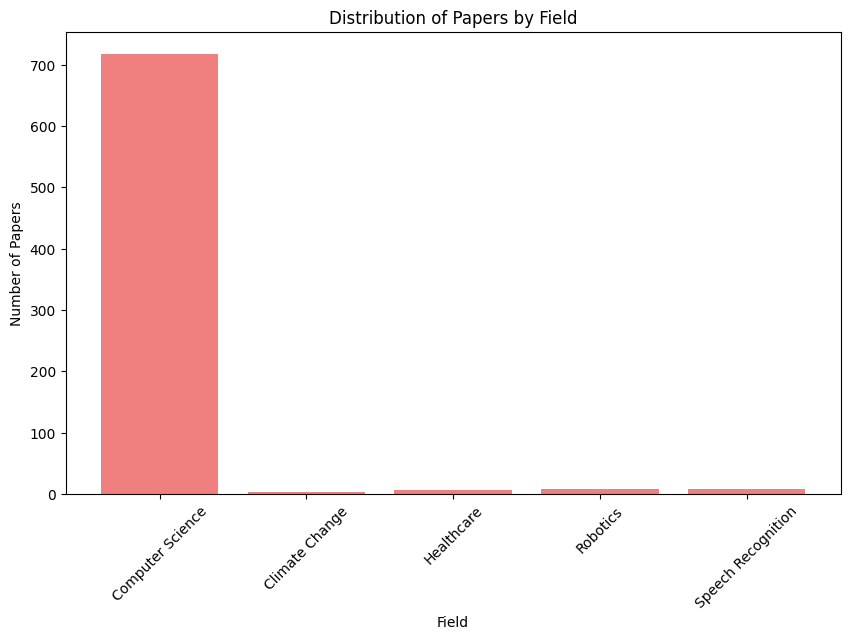

In [30]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from PyPDF2 import PdfReader

from google.colab import drive
drive.mount('/content/drive')

# defined keywords for each field can add...
field_keywords = {
    'Computer Science': ['computer science', 'algorithm', 'machine learning', 'artificial intelligence', 'data structure'],
    'Robotics': ['robotics', 'robot', 'autonomous', 'manipulator', 'actuator'],
    'Climate Change': ['climate change', 'global warming', 'greenhouse gas', 'carbon dioxide', 'environmental'],
    'Healthcare': ['healthcare', 'medical', 'clinical', 'patient', 'disease'],
    'Finance': ['finance', 'financial', 'banking', 'investment', 'stock market'],
    'Autonomous Vehicles': ['autonomous vehicle', 'self-driving', 'driverless', 'automotive', 'vehicle navigation'],
    'Speech Recognition': ['speech recognition', 'speech processing', 'voice recognition', 'audio processing', 'acoustic model'],
}

# function to determine the field of a paper based on keywords
def determine_field(text, field_keywords):
    for field, keywords in field_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                return field
    return 'Unknown'  # if no keywords match, return 'Unknown'

text_folder = '/content/drive/My Drive/TextPapers/'
field_counts = Counter()

for text_file in tqdm(os.listdir(text_folder)):
    if text_file.endswith('.txt'):
        with open(f"{text_folder}{text_file}", 'r', encoding='utf-8') as file:
            text = file.read()
            field = determine_field(text, field_keywords)
            field_counts[field] += 1

if 'Unknown' in field_counts:
    del field_counts['Unknown']

plt.figure(figsize=(10, 6))
plt.bar(field_counts.keys(), field_counts.values(), color='lightcoral')
plt.xlabel('Field')
plt.ylabel('Number of Papers')
plt.title('Distribution of Papers by Field')
plt.xticks(rotation=45)
plt.show()


Ethics of AI: Ethical considerations

100%|██████████| 780/780 [00:05<00:00, 137.63it/s]


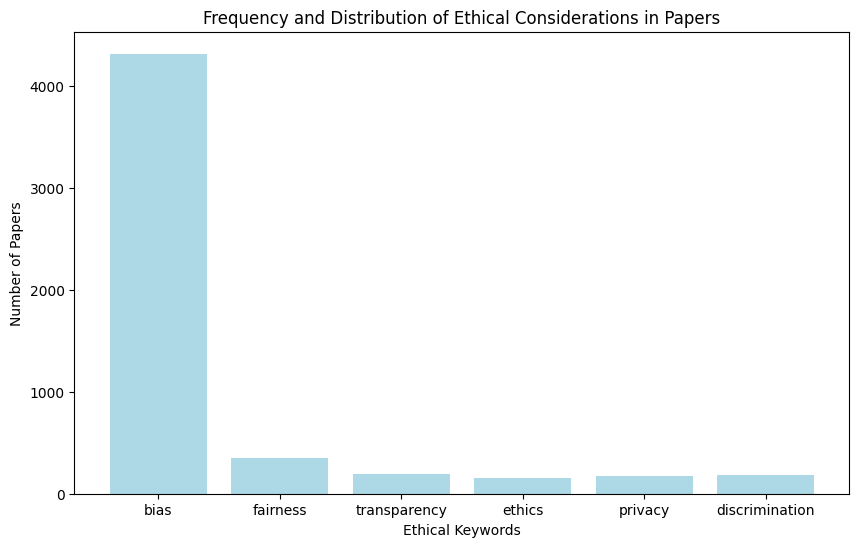

In [26]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# defines the specific ethical keywords of interest
ethical_keywords = ['bias', 'fairness', 'transparency', 'ethics', 'privacy', 'discrimination']

def count_ethical_keywords(text, ethical_keywords):
    counts = {keyword: text.lower().count(keyword.lower()) for keyword in ethical_keywords}
    return counts

text_folder = '/content/drive/My Drive/TextPapers/'
ethical_counts = Counter()

for text_file in tqdm(os.listdir(text_folder)):
    if text_file.endswith('.txt'):
        with open(f"{text_folder}{text_file}", 'r', encoding='utf-8') as file:
            text = file.read()
            counts = count_ethical_keywords(text, ethical_keywords)
            ethical_counts.update(counts)

plt.figure(figsize=(10, 6))
plt.bar(ethical_counts.keys(), ethical_counts.values(), color='lightblue')
plt.xlabel('Ethical Keywords')
plt.ylabel('Number of Papers')
plt.title('Frequency and Distribution of Ethical Considerations in Papers')
plt.show()



In [ ]:
# ### side by side in Times New Roman ### this doesn't run due to crashing -- memory issue

# from google.colab import drive
# drive.mount('/content/drive')

# !pip install fuzzywuzzy[speedup]
# import pandas as pd
# import os
# from collections import Counter
# import spacy
# from nltk.corpus import stopwords
# import nltk
# from fuzzywuzzy import process
# import matplotlib.pyplot as plt
# !pip install wordninja

# import wordninja

# nltk.download('stopwords')

# nlp = spacy.load("en_core_web_sm")

# stop_words = set(stopwords.words('english')).union({'et', 'al'})

# def is_real_word(word):
#     """Checks if a word is a real word by splitting it and checking if the split parts are in the English dictionary."""
#     split_words = wordninja.split(word)
#     return all(split_word in nlp.vocab for split_word in split_words)

# def perform_keyword_analysis(text):
#     """Performs keyword analysis on text, using lemmatization and excluding stopwords and non-real words."""
#     nlp.max_length = len(text) + 10000
#     doc = nlp(text)
#     lemmas = [token.lemma_.lower() for token in doc if token.lemma_ not in stop_words and token.pos_ != 'PUNCT' and not token.lemma_.isdigit() and len(token.lemma_) > 1 and not token.lemma_.startswith('/')]
#     filtered_lemmas = [lemma for lemma in lemmas if is_real_word(lemma)]
#     lemma_freq = Counter(filtered_lemmas)
#     return lemma_freq.most_common()

# def find_best_match(name, choices, threshold=80):
#     """Gets the best match for a given name from a list of choices, with a minimum similarity threshold."""
#     match = process.extractOne(name, choices)
#     if match:
#         best_match, score, _ = match
#         if score >= threshold:
#             return best_match
#     return None

# pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/all_systems.csv")

# # Step 1: Get publication year
# pcd_dataset['Publication Year'] = pd.to_datetime(pcd_dataset['Publication date']).dt.year

# # Preprocess the System names in the dataset
# processed_system_names = pcd_dataset['System'].str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')

# # Step 2: Group text files by publication year
# text_files_by_year = {}
# text_folder = '/content/drive/My Drive/TextPapers/'
# for text_file in os.listdir(text_folder):
#     article_name = text_file.replace('.txt', '').replace('_', ' ')
#     best_match = find_best_match(article_name, processed_system_names)
#     if best_match is None:
#         print(f"Warning: No matching entry found in dataset for text file '{text_file}'")
#         continue
#     year = pcd_dataset[processed_system_names == best_match]['Publication Year'].values[0]
#     if year not in text_files_by_year:
#         text_files_by_year[year] = []
#     with open(f'{text_folder}{text_file}', 'r', encoding='utf-8') as f:
#         text_content = f.read()
#         text_files_by_year[year].append(text_content)

# # Step 3: Keyword analysis for each year
# keywords_by_year = {}
# papers_count_by_year = {}
# for year, texts in text_files_by_year.items():
#     all_text = ' '.join(texts)
#     keywords_by_year[year] = perform_keyword_analysis(all_text)
#     papers_count_by_year[year] = len(texts)

# # identify the top 10 keywords across all years
# all_keywords_freq = Counter()
# for year, keywords in keywords_by_year.items():
#     all_keywords_freq.update(dict(keywords))
# top_10_keywords = [keyword for keyword, _ in all_keywords_freq.most_common(10)]

# top_keywords_freq_by_year = {year: {keyword: 0 for keyword in top_10_keywords} for year in sorted(keywords_by_year.keys())}
# for year, keywords in keywords_by_year.items():
#     year_keywords_freq = dict(keywords)
#     for keyword in top_10_keywords:
#         top_keywords_freq_by_year[year][keyword] = year_keywords_freq.get(keyword, 0)

# # new format
# plt.rcParams['font.family'] = 'Times New Roman'
# fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# # plot the first graph (Top 10 Keywords in All Papers)
# keyword_analysis, total_keywords = perform_keyword_analysis(text_folder)
# top_keywords = keyword_analysis[:10]
# keywords, counts = zip(*top_keywords)
# keywords = list(keywords)
# counts = list(counts)
# axs[0].barh(keywords, counts)
# axs[0].set_xlabel('Frequency')
# axs[0].set_title('Top 10 Keywords in All Papers')
# axs[0].invert_yaxis()  # Invert y-axis to display the highest frequency at the top

# # plot the second graph (Top 10 Keywords Frequency Trend Over Time)
# for keyword in top_10_keywords:
#     axs[1].plot(list(top_keywords_freq_by_year.keys()), [top_keywords_freq_by_year[year][keyword] for year in sorted(top_keywords_freq_by_year.keys())], label=keyword)
# axs[1].set_xlabel('Year')
# axs[1].set_ylabel('Frequency')
# axs[1].set_title('Top 10 Keywords Frequency Trend Over Time')
# axs[1].legend()
# axs[1].grid(True)

# plt.tight_layout()
# plt.show()

# total_papers_analyzed = sum(papers_count_by_year.values())
# print(f"Total papers analyzed: {total_papers_analyzed}")

# for year, count in papers_count_by_year.items():
#     print(f"Year {year}: {count} papers analyzed")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
import spacy
import os
import matplotlib.pyplot as plt
!pip install wordninja

import wordninja

# Load the English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

def is_real_word(word):
    """Checks if a word is a real word by splitting it and checking if the split parts are in the English dictionary."""
    split_words = wordninja.split(word)
    return all(split_word in nlp.vocab for split_word in split_words)

def perform_keyword_analysis(text_folder='/content/drive/My Drive/TextPapers/'):
    """Perform keyword analysis on text files, using lemmatization to reduce words to their base form and excluding non-real words."""
    stop_words = set(stopwords.words('english')).union({'et', 'al'})
    keyword_counts = Counter()
    for text_file in tqdm(os.listdir(text_folder)):
        if text_file.endswith('.txt'):
            with open(f"{text_folder}{text_file}", 'r', encoding='utf-8') as f:
                text = f.read().lower()
                doc = nlp(text)
                lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words and len(token.lemma_) > 1 and not token.lemma_.startswith('/') and not token.lemma_.isdigit()]
                filtered_lemmas = [lemma for lemma in lemmas if is_real_word(lemma)]
                keyword_counts.update(filtered_lemmas)
    total_keywords = len(keyword_counts)
    return keyword_counts.most_common(), total_keywords

keyword_analysis, total_keywords = perform_keyword_analysis()
top_keywords = keyword_analysis[:10]
print(f"Top 10 keywords: {top_keywords}")
print(f"Total number of unique keywords assessed: {total_keywords}")

# Create a horizontal bar plot for the top keywords
keywords, counts = zip(*top_keywords)
keywords = list(keywords)
counts = list(counts)
plt.figure(figsize=(12, 8))
plt.barh(keywords, counts)
plt.ylabel('Keywords')
plt.xlabel('Frequency')
plt.title('Top 10 Keywords in All Papers')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest frequency at the top
plt.show()




In [ ]:
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
import spacy
import os
import matplotlib.pyplot as plt
!pip install wordninja

import wordninja

# Load the English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

def is_real_word(word):
    """Checks if a word is a real word by splitting it and checking if the split parts are in the English dictionary."""
    split_words = wordninja.split(word)
    return all(split_word in nlp.vocab for split_word in split_words)

def perform_keyword_analysis(text_folder='/content/drive/My Drive/TextPapers/'):
    """Perform keyword analysis on text files, using lemmatization to reduce words to their base form and excluding non-real words."""
    stop_words = set(stopwords.words('english')).union({'et', 'al'})
    keyword_counts = Counter()
    total_papers = 0
    for text_file in tqdm(os.listdir(text_folder)):
        if text_file.endswith('.txt'):
            total_papers += 1
            with open(f"{text_folder}{text_file}", 'r', encoding='utf-8') as f:
                text = f.read().lower()
                doc = nlp(text)
                lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words and len(token.lemma_) > 1 and not token.lemma_.startswith('/') and not token.lemma_.isdigit()]
                filtered_lemmas = [lemma for lemma in lemmas if is_real_word(lemma)]
                keyword_counts.update(filtered_lemmas)
    total_keywords = len(keyword_counts)
    return keyword_counts.most_common(), total_keywords, total_papers

keyword_analysis, total_keywords, total_papers = perform_keyword_analysis()
top_keywords = keyword_analysis[:10]
print(f"Top 10 keywords: {top_keywords}")
print(f"Total number of unique keywords assessed: {total_keywords}")
print(f"Total number of papers analyzed: {total_papers}")

# bar plot for the top keywords (absolute frequency)
keywords, counts = zip(*top_keywords)
keywords = list(keywords)
counts = list(counts)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(keywords, counts)
plt.ylabel('Keywords')
plt.xlabel('Frequency (Absolute)')
plt.title('Top 10 Keywords Frequency (Absolute)')
plt.gca().invert_yaxis()

# new add: bar plot for the top keywords (relative frequency)
relative_counts = [count / total_papers * 100 for count in counts]
plt.subplot(1, 2, 2)
plt.barh(keywords, relative_counts)
plt.ylabel('Keywords')
plt.xlabel('Frequency (Relative %)')
plt.title('Top 10 Keywords Frequency (Relative %)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


# Keyword Extraction over time

Question: What is the frequency of the top keywords over time?
(I combine this into

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install fuzzywuzzy[speedup]
import pandas as pd
import os
from collections import Counter
import spacy
from nltk.corpus import stopwords
import nltk
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import wordninja

nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english')).union({'et', 'al'})

def is_real_word(word):
    """Checks if a word is a real word by splitting it and checking if the split parts are in the English dictionary."""
    split_words = wordninja.split(word)
    return all(split_word in nlp.vocab for split_word in split_words)

def perform_keyword_analysis(text):
    """Performs keyword analysis on text, using lemmatization and excluding stopwords and non-real words."""
    nlp.max_length = len(text) + 10000
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if token.lemma_ not in stop_words and token.pos_ != 'PUNCT' and not token.lemma_.isdigit() and len(token.lemma_) > 1 and not token.lemma_.startswith('/')]
    filtered_lemmas = [lemma for lemma in lemmas if is_real_word(lemma)]
    lemma_freq = Counter(filtered_lemmas)
    return lemma_freq.most_common()

def find_best_match(name, choices, threshold=80):
    """Gets the best match for a given name from a list of choices, with a minimum similarity threshold."""
    match = process.extractOne(name, choices)
    if match:
        best_match, score, _ = match
        if score >= threshold:
            return best_match
    return None

pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/all_systems.csv")

# Step 1: Get publication year
pcd_dataset['Publication Year'] = pd.to_datetime(pcd_dataset['Publication date']).dt.year

# Preprocess the System names in the dataset
processed_system_names = pcd_dataset['System'].str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')

# Step 2: Group text files by publication year
text_files_by_year = {}
text_folder = '/content/drive/My Drive/TextPapers/'
for text_file in os.listdir(text_folder):
    article_name = text_file.replace('.txt', '').replace('_', ' ')
    best_match = find_best_match(article_name, processed_system_names)
    if best_match is None:
        print(f"Warning: No matching entry found in dataset for text file '{text_file}'")
        continue
    year = pcd_dataset[processed_system_names == best_match]['Publication Year'].values[0]
    if year not in text_files_by_year:
        text_files_by_year[year] = []
    with open(f'{text_folder}{text_file}', 'r', encoding='utf-8') as f:
        text_content = f.read()
        text_files_by_year[year].append(text_content)

# Step 3: Keyword analysis for each year
keywords_by_year = {}
papers_count_by_year = {}
for year, texts in text_files_by_year.items():
    all_text = ' '.join(texts)
    keywords_by_year[year] = perform_keyword_analysis(all_text)
    papers_count_by_year[year] = len(texts)

# Identify the top 10 keywords across all years
all_keywords_freq = Counter()
for year, keywords in keywords_by_year.items():
    all_keywords_freq.update(dict(keywords))
top_10_keywords = [keyword for keyword, _ in all_keywords_freq.most_common(10)]

# Track the frequency of the top 10 keywords over each year
top_keywords_freq_by_year = {year: {keyword: 0 for keyword in top_10_keywords} for year in sorted(keywords_by_year.keys())}
for year, keywords in keywords_by_year.items():
    year_keywords_freq = dict(keywords)
    for keyword in top_10_keywords:
        top_keywords_freq_by_year[year][keyword] = year_keywords_freq.get(keyword, 0)

# Plot the frequency of the top 10 keywords over time
plt.figure(figsize=(12, 8))
for keyword in top_10_keywords:
    plt.plot(list(top_keywords_freq_by_year.keys()), [top_keywords_freq_by_year[year][keyword] for year in sorted(top_keywords_freq_by_year.keys())], label=keyword)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Top 10 Keywords Frequency Trend Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Print total papers analyzed
total_papers_analyzed = sum(papers_count_by_year.values())
print(f"Total papers analyzed: {total_papers_analyzed}")

# Print papers analyzed per year
for year, count in papers_count_by_year.items():
    print(f"Year {year}: {count} papers analyzed")



In [ ]:
import matplotlib.pyplot as plt

# absolute frequency of the top 10 keywords over time
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
for keyword in top_10_keywords:
    plt.plot(list(top_keywords_freq_by_year.keys()), [top_keywords_freq_by_year[year][keyword] for year in sorted(top_keywords_freq_by_year.keys())], label=keyword)
plt.xlabel('Year')
plt.ylabel('Frequency (Absolute)')
plt.title('Top 10 Keywords Frequency Trend Over Time (Absolute)')
plt.legend()
plt.grid(True)

# relative frequency of the top 10 keywords over time
plt.subplot(1, 2, 2)
for keyword in top_10_keywords:
    plt.plot(list(top_keywords_freq_by_year.keys()), [top_keywords_freq_by_year[year][keyword] / papers_count_by_year[year] * 100 for year in sorted(top_keywords_freq_by_year.keys())], label=keyword)
plt.xlabel('Year')
plt.ylabel('Frequency (Relative %)')
plt.title('Top 10 Keywords Frequency Trend Over Time (Relative %)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
